In [2]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantaotao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import networkx as nx
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
sys.path.append("/home/jtao/code/seq_merge_pipe/")
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/motif_orientation_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
%env PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin


## Functions

In [25]:
# split data into GC content matched training and test data
def get_GC_matched_split(features, labels, test_size, tolerance = 0.01):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    tolerance: max difference in GC content between True and False labelled samples
    '''
    global _id_sequence_dict
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if x[1]]
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if not x[1]]
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    # calculate GC content of True samples
    true_gc_count = 0
    true_length = 0
    for s in true_sequences:
        true_gc_count += s.count('G')
        true_gc_count += s.count('C')
        true_length += len(s)
    true_gc_content = true_gc_count/(true_length+0.0000001)
    
    # calcuate GC content of False samples
    false_gc_count = 0
    false_length = 0
    for s in false_sequences:
        false_gc_count += s.count('G')
        false_gc_count += s.count('C')
        false_length += len(s)
    false_gc_content = false_gc_count/(false_length+0.0000001)
    
    while abs(true_gc_content - false_gc_content) > tolerance:
        # remove false GC sequences until GC content matches tolerance
        selected_seq = False
        
        while not selected_seq:
            rand_index = np.random.randint(len(false_sequences))
            current_seq = false_sequences[rand_index]
            current_gc_count = current_seq.count('G')+ current_seq.count('C')
            current_length = len(current_seq)
            current_gc = current_gc_count/current_length
            if true_gc_content > false_gc_content:
                # remove sequences that would increase overall GC content of False sequences
                if current_gc < false_gc_content:
                    selected_seq = True
            else:
                # remove sequences that would decrease overall GC content of False sequences
                if current_gc > false_gc_content:
                    selected_seq = True
        false_gc_count -= current_gc_count
        false_length -= current_length
        false_gc_content = false_gc_count/false_length
        
        false_sequences.pop(rand_index)
        false_ids.pop(rand_index)
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [9]:
# create a script to scan for motifs using FIMO
! if [ ! -d /home/jtao/analysis/cobinding_motif_analysis/fimo_out/ ]; then mkdir /home/jtao/analysis/cobinding_motif_analysis/fimo_out/; fi
! rm -rf fimo_out/*
! rm -rf fimo_result/*


pthresh = 0.01
motif_dir = '/home/jtao/analysis/cobinding_motif_analysis/fimo_motifs/'

fimo_results_dir = './fimo_results'

fastaFile = 'C57BL6J.fa'
print(fastaFile)
strain = fastaFile.split('.')[0]
count = 0
scriptFile = open('scanMotifs_'+ strain +'.sh','w')
for m in os.listdir(motif_dir):
    if 'fimo' in m:
        fimo_out_dir = './fimo_out/' + strain + '_' +m.replace('.fimo','')
        outPath = fimo_results_dir + '/' +strain + '_' + m.replace('.fimo','') +'.txt'
        scriptFile.write(
#             '(sleep ' + str(15 * count) + 
            '(sleep ' + str(0 * count) + 
            's; fimo --text --max-stored-scores 2000000 --output-pthresh ' + 
            str(pthresh) +' --oc ' + fimo_out_dir + ' ' +
            motif_dir + '/' + m + ' ./' + fastaFile +
            '> ' + outPath + ' ) & \n')
        count+=1
scriptFile.close()




C57BL6J.fa


In [ ]:
%%bash
if [ ! -d ./fimo_results ]; then mkdir ./fimo_results; else rm -rf ./fimo_results/*; fi
chmod a+x ./scanMotifs*
./scanMotifs_C57BL6J.sh


In [17]:
# read in peak data data
summary_frame = pd.read_csv('./group_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.max([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
summary_frame.index = summary_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_frame = summary_frame[~summary_frame['chr'].str.contains('random')]
summary_frame = summary_frame[~summary_frame['chr'].str.contains('Un')]
_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
summary_frame.to_pickle('summary_frame.pickle')

In [15]:
motif_dir = '/home/jtao/analysis/cobinding_motif_analysis/fimo_motifs/'
# motif_dir = '/home/jtao/analysis/cobinding_motif_analysis/fimo_motifs_jaspar_2014/'


fastaFile = 'C57BL6J.fa'

strain = fastaFile.split('.')[0]

peak_start_dict = dict(zip(summary_frame['ID'].values, summary_frame['start'].values))

motif_score_frame = summary_frame[['ID', 'Factors', 'chr']]
motif_score_frame.index=motif_score_frame['ID'].values

motif_sequence_frame = summary_frame[['ID', 'Factors', 'chr']]
motif_sequence_frame.index=motif_score_frame['ID'].values

motif_strand_frame = summary_frame[['ID', 'Factors', 'chr']]
motif_strand_frame.index=motif_score_frame['ID'].values

motif_start_frame = summary_frame[['ID', 'Factors', 'chr']]
motif_start_frame.index=motif_score_frame['ID'].values

motif_end_frame = summary_frame[['ID', 'Factors', 'chr']]
motif_end_frame.index=motif_score_frame['ID'].values

motif_count_frame = summary_frame[['ID', 'Factors', 'chr']]
motif_count_frame.index = motif_count_frame['ID'].values

counter=0
for m in sorted(os.listdir(motif_dir)):
    counter+=1
    if '.fimo' in m:
        print(counter,m)
        motif_results = './fimo_results/' + strain + '_' + m.replace('.fimo','') +'.txt'
        fimo_result_frame=pd.read_csv(motif_results, 
                                      skiprows=1,
                                      names=['motif_name', 
                                             'peak_id', 
                                             'start', 
                                             'stop', 
                                             'strand', 
                                             'score', 
                                             'pvalue', 
                                             'sequence'],
                                      sep='\t')
        motif_name = m.replace('.fimo','')

        id_count_forward_dict = {} #{PeakID:motifCount}
        id_values_forward_dict = {} # {PeakID:(motifScore, motifSequence, motifStrand, motifStart, motifEnd)}
        id_count_reverse_dict = {} #{PeakID:motifCount}
        id_values_reverse_dict = {} # {PeakID:(motifScore, motifSequence, motifStrand, motifStart, motifEnd)}


        ids = fimo_result_frame['peak_id'].values
        scores = fimo_result_frame['score'].values
        strands = fimo_result_frame['strand'].values
        sequences = fimo_result_frame['sequence']
        starts = fimo_result_frame['start']
        ends = fimo_result_frame['stop']

        for i in range(len(ids)):
            currentScore = float(scores[i])
            currentSequence = sequences[i]
            currentStrand = strands[i]
            currentStart = int(starts[i])
            currentEnd = int(ends[i])

            if currentScore < 0.0:
                currentScore = 0.0


            values = (currentScore, currentSequence, currentStrand, currentStart, currentEnd)
            
            if currentStrand == '+':
                if ids[i] in id_values_forward_dict:
                    if currentScore > id_values_forward_dict[ids[i]][0]:
                        id_values_forward_dict[ids[i]] = values
                        id_count_forward_dict[ids[i]] += 1
                else:
                    id_values_forward_dict[ids[i]] = values
                    id_count_forward_dict[ids[i]] = 1
            else:
                if ids[i] in id_values_reverse_dict:
                    if currentScore > id_values_reverse_dict[ids[i]][0]:
                        id_values_reverse_dict[ids[i]] = values
                        id_count_reverse_dict[ids[i]] += 1
                else:
                    id_values_reverse_dict[ids[i]] = values
                    id_count_reverse_dict[ids[i]] = 1


        sorted_forward_values = [id_values_forward_dict[x] if x in id_values_forward_dict else (0,'','?',-1,-1,0) for x in  motif_score_frame['ID'].values]
        sorted_forward_scores = [x[0] for x in sorted_forward_values]
        sorted_forward_sequences = [x[1] for x in sorted_forward_values]
        sorted_forward_strands = [x[2] for x in sorted_forward_values]
        sorted_forward_starts = [x[3] for x in sorted_forward_values]
        sorted_forward_ends = [x[4] for x in sorted_forward_values]
        sorted_forward_counts = [id_count_forward_dict[x] if x in id_count_forward_dict else 0 for x in motif_score_frame['ID'].values]
        
        sorted_reverse_values = [id_values_reverse_dict[x] if x in id_values_reverse_dict else (0,'','?',-1,-1,0) for x in  motif_score_frame['ID'].values]
        sorted_reverse_scores = [x[0] for x in sorted_reverse_values]
        sorted_reverse_sequences = [x[1] for x in sorted_reverse_values]
        sorted_reverse_strands = [x[2] for x in sorted_reverse_values]
        sorted_reverse_starts = [x[3] for x in sorted_reverse_values]
        sorted_reverse_ends = [x[4] for x in sorted_reverse_values]
        sorted_reverse_counts = [id_count_reverse_dict[x] if x in id_count_reverse_dict else 0 for x in motif_score_frame['ID'].values]

        motif_score_frame[motif_name + '_+'] = sorted_forward_scores
        motif_sequence_frame[motif_name + '_+'] = sorted_forward_sequences
        motif_strand_frame[motif_name + '_+'] = sorted_forward_strands
        motif_start_frame[motif_name + '_+'] = sorted_forward_starts
        motif_end_frame[motif_name + '_+'] = sorted_forward_ends
        motif_count_frame[motif_name + '_+'] = sorted_forward_counts

        motif_score_frame[motif_name + '_-'] = sorted_reverse_scores
        motif_sequence_frame[motif_name + '_-'] = sorted_reverse_sequences
        motif_strand_frame[motif_name + '_-'] = sorted_reverse_strands
        motif_start_frame[motif_name + '_-'] = sorted_reverse_starts
        motif_end_frame[motif_name + '_-'] = sorted_reverse_ends
        motif_count_frame[motif_name + '_-'] = sorted_reverse_counts
        
motif_score_frame.to_pickle('motif_score_frame_'+  strain + '.pickle')
motif_score_frame.to_csv('motif_scores_'+  strain + '.tsv', sep='\t', index=False)

motif_sequence_frame.to_pickle('motif_sequence_frame_'+  strain + '.pickle')
motif_sequence_frame.to_csv('motif_sequence_'+  strain + '.tsv', sep='\t', index=False)

motif_strand_frame.to_pickle('motif_strand_frame_'+  strain + '.pickle')
motif_strand_frame.to_csv('motif_strand_'+  strain + '.tsv', sep='\t', index=False)

motif_start_frame.to_pickle('motif_start_frame_'+  strain + '.pickle')
motif_start_frame.to_csv('motif_start_frame_'+  strain + '.tsv', sep='\t', index=False)

motif_end_frame.to_pickle('motif_end_frame_'+  strain + '.pickle')
motif_end_frame.to_csv('motif_end_frame_'+  strain + '.tsv', sep='\t', index=False)

motif_count_frame.to_pickle('motif_count_frame_'+  strain + '.pickle')
motif_count_frame.to_csv('motif_count_frame_'+  strain + '.tsv', sep='\t', index=False)



1 alx1_alx4_arx.fimo


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

2 ap-1.fimo
3 ar_nr3c1_nr3c2.fimo
4 arid3a.fimo
5 arid3b.fimo
6 arid5a.fimo
7 arnt_mycn.fimo
8 arntl_mitf.fimo
9 ascl2_nhlh1.fimo
10 atf7_batf3_creb5.fimo
11 bcl6.fimo
12 bcl6b.fimo
13 bhlh.fimo
14 bhlha15.fimo
15 bhlhe23.fimo
16 cdx.fimo
17 cebp.fimo
18 cenpb.fimo
19 creb3-l1.fimo
20 crem.fimo
21 ctcf.fimo
22 cux.fimo
23 dbp_hlf_tef.fimo
24 dmbx1.fimo
25 dmrt3.fimo
26 dux.fimo
27 dux4.fimo
28 duxa.fimo
29 e2f1.fimo
30 e2f2.fimo
31 e2f4_e2f6.fimo
32 e2f7.fimo
33 e2f8.fimo
34 ebf1.fimo
35 ebox.fimo
36 egr.fimo
37 elf.fimo
38 elk_etv.fimo
39 esr1.fimo
40 esr2.fimo
41 esrr.fimo
42 ewsr1-fli1.fimo
43 figla_id4_snai2_tcf3_tcf4.fimo
44 fox.fimo
45 gata.fimo
46 gcm.fimo
47 gfi1.fimo
48 gfi1b.fimo
49 gli2.fimo
50 glis.fimo
51 gmeb2.fimo
52 grhl1.fimo
53 gsc.fimo
54 hes.fimo
55 hic.fimo
56 hinfp.fimo
57 hltf.fimo
58 hnf1.fimo
59 hnf4a.fimo
60 hnf4g.fimo
61 homeobox-1.fimo
62 homeobox-2.fimo
63 homeobox-3.fimo
64 homeobox-4.fimo
65 homeobox-5.fimo
66 hoxa11.fimo
67 hoxa5.fimo
68 hoxa9.fimo
69 ho

In [19]:
motif_score_frame=pd.read_pickle('motif_score_frame_C57BL6J.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame_C57BL6J.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame_C57BL6J.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame_C57BL6J.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame_C57BL6J.pickle')
motif_count_frame = pd.read_pickle('motif_count_frame_C57BL6J.pickle')
summary_frame = pd.read_pickle('summary_frame.pickle')

# normed_motif_frame = pd.DataFrame(preprocessing.normalize(merged_motif_frame.ix[:,3:], axis=0))
scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values
_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
_factors.remove('atac')
scaler = preprocessing.MinMaxScaler()
normed_summary_frame = pd.DataFrame(scaler.fit_transform(summary_frame.ix[:,5:]))
normed_summary_frame.columns = summary_frame.columns.values[5:]
normed_summary_frame.index = summary_frame.index.values

scaled_motif_frame = pd.DataFrame()
for m in motif_score_frame.columns[3:]:
    scaled_motif_frame[m] = motif_score_frame[m]/(2*motif_sequence_frame[m].str.len().max())
    
    
### read in sequences as dictionary {peakID: sequence}
with open('./C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()    

In [23]:
factorPairs = []
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
for i in range(len(ap1_members)-1):
    for j in range(i+1, len(ap1_members)):
        factorPairs.append(('c57bl6_'+ap1_members[i],'c57bl6_'+ ap1_members[j]))

In [26]:
### for all peaks in vehicle for all motifs
numIterations = 1
factor_coeff_dict = {}
factor_auc_dict_veh = {}
factor_prob_dict_veh = {}
# c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']

c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_veh' for x in factors]].sum(axis=1) > 0].index.values  


for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[0] + '_veh') & \
             summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[1] + '_veh')
    all_aucs = []
    all_coeficients = []
    all_probs = None
    for i in range(numIterations):    
        # split data into training and test sets
        training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = 0.5, tolerance = 0.01)

        #  Run classifier
        lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

        lr_classifier.fit(training_features, training_labels)
        # retreive probabilities for each classifier
        probas_lr = lr_classifier.predict_proba(test_features)
        # retrieve predictions for each classifier
        fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])\

        current_roc_auc = auc(fpr, tpr)
        all_aucs.append(current_roc_auc)
        
        # score all sequences
        probs = lr_classifier.predict_proba(features)[:, 1]
        
        current_coefficients = lr_classifier.coef_.flatten()
        all_coeficients.append(current_coefficients)
        
        if all_probs == None:
            all_probs = probs
        else:
            all_probs = all_probs + probs
    all_probs = all_probs/numIterations
    mean_roc_auc = np.mean(all_aucs) # average aucROC
    mean_coefficients = np.mean(all_coeficients, axis=0) # average coefficients 
    
    factor_auc_dict_veh['_'.join(factorPair).replace('c57bl6_','')]= mean_roc_auc
    factor_coeff_dict['_'.join(factorPair).replace('c57bl6_','')] = mean_coefficients
    factor_prob_dict_veh['_'.join(factorPair).replace('c57bl6_','')] = all_probs
    print(factorPair, mean_roc_auc)
coefficients_frame_veh = pd.DataFrame(factor_coeff_dict)
coefficients_frame_veh.index = normed_motif_frame.columns.values
probs_frame_veh = pd.DataFrame(factor_prob_dict_veh,
                              index = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)].index.values)



('c57bl6_atf3', 'c57bl6_cjun') 0.813566369712
('c57bl6_atf3', 'c57bl6_fos') 0.863492473774
('c57bl6_atf3', 'c57bl6_junb') 0.794199090027
('c57bl6_atf3', 'c57bl6_jund') 0.818962695839
('c57bl6_cjun', 'c57bl6_fos') 0.856069359007
('c57bl6_cjun', 'c57bl6_junb') 0.788983020601
('c57bl6_cjun', 'c57bl6_jund') 0.811513245383
('c57bl6_fos', 'c57bl6_junb') 0.773432225158
('c57bl6_fos', 'c57bl6_jund') 0.856002489356
('c57bl6_junb', 'c57bl6_jund') 0.771064764819


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


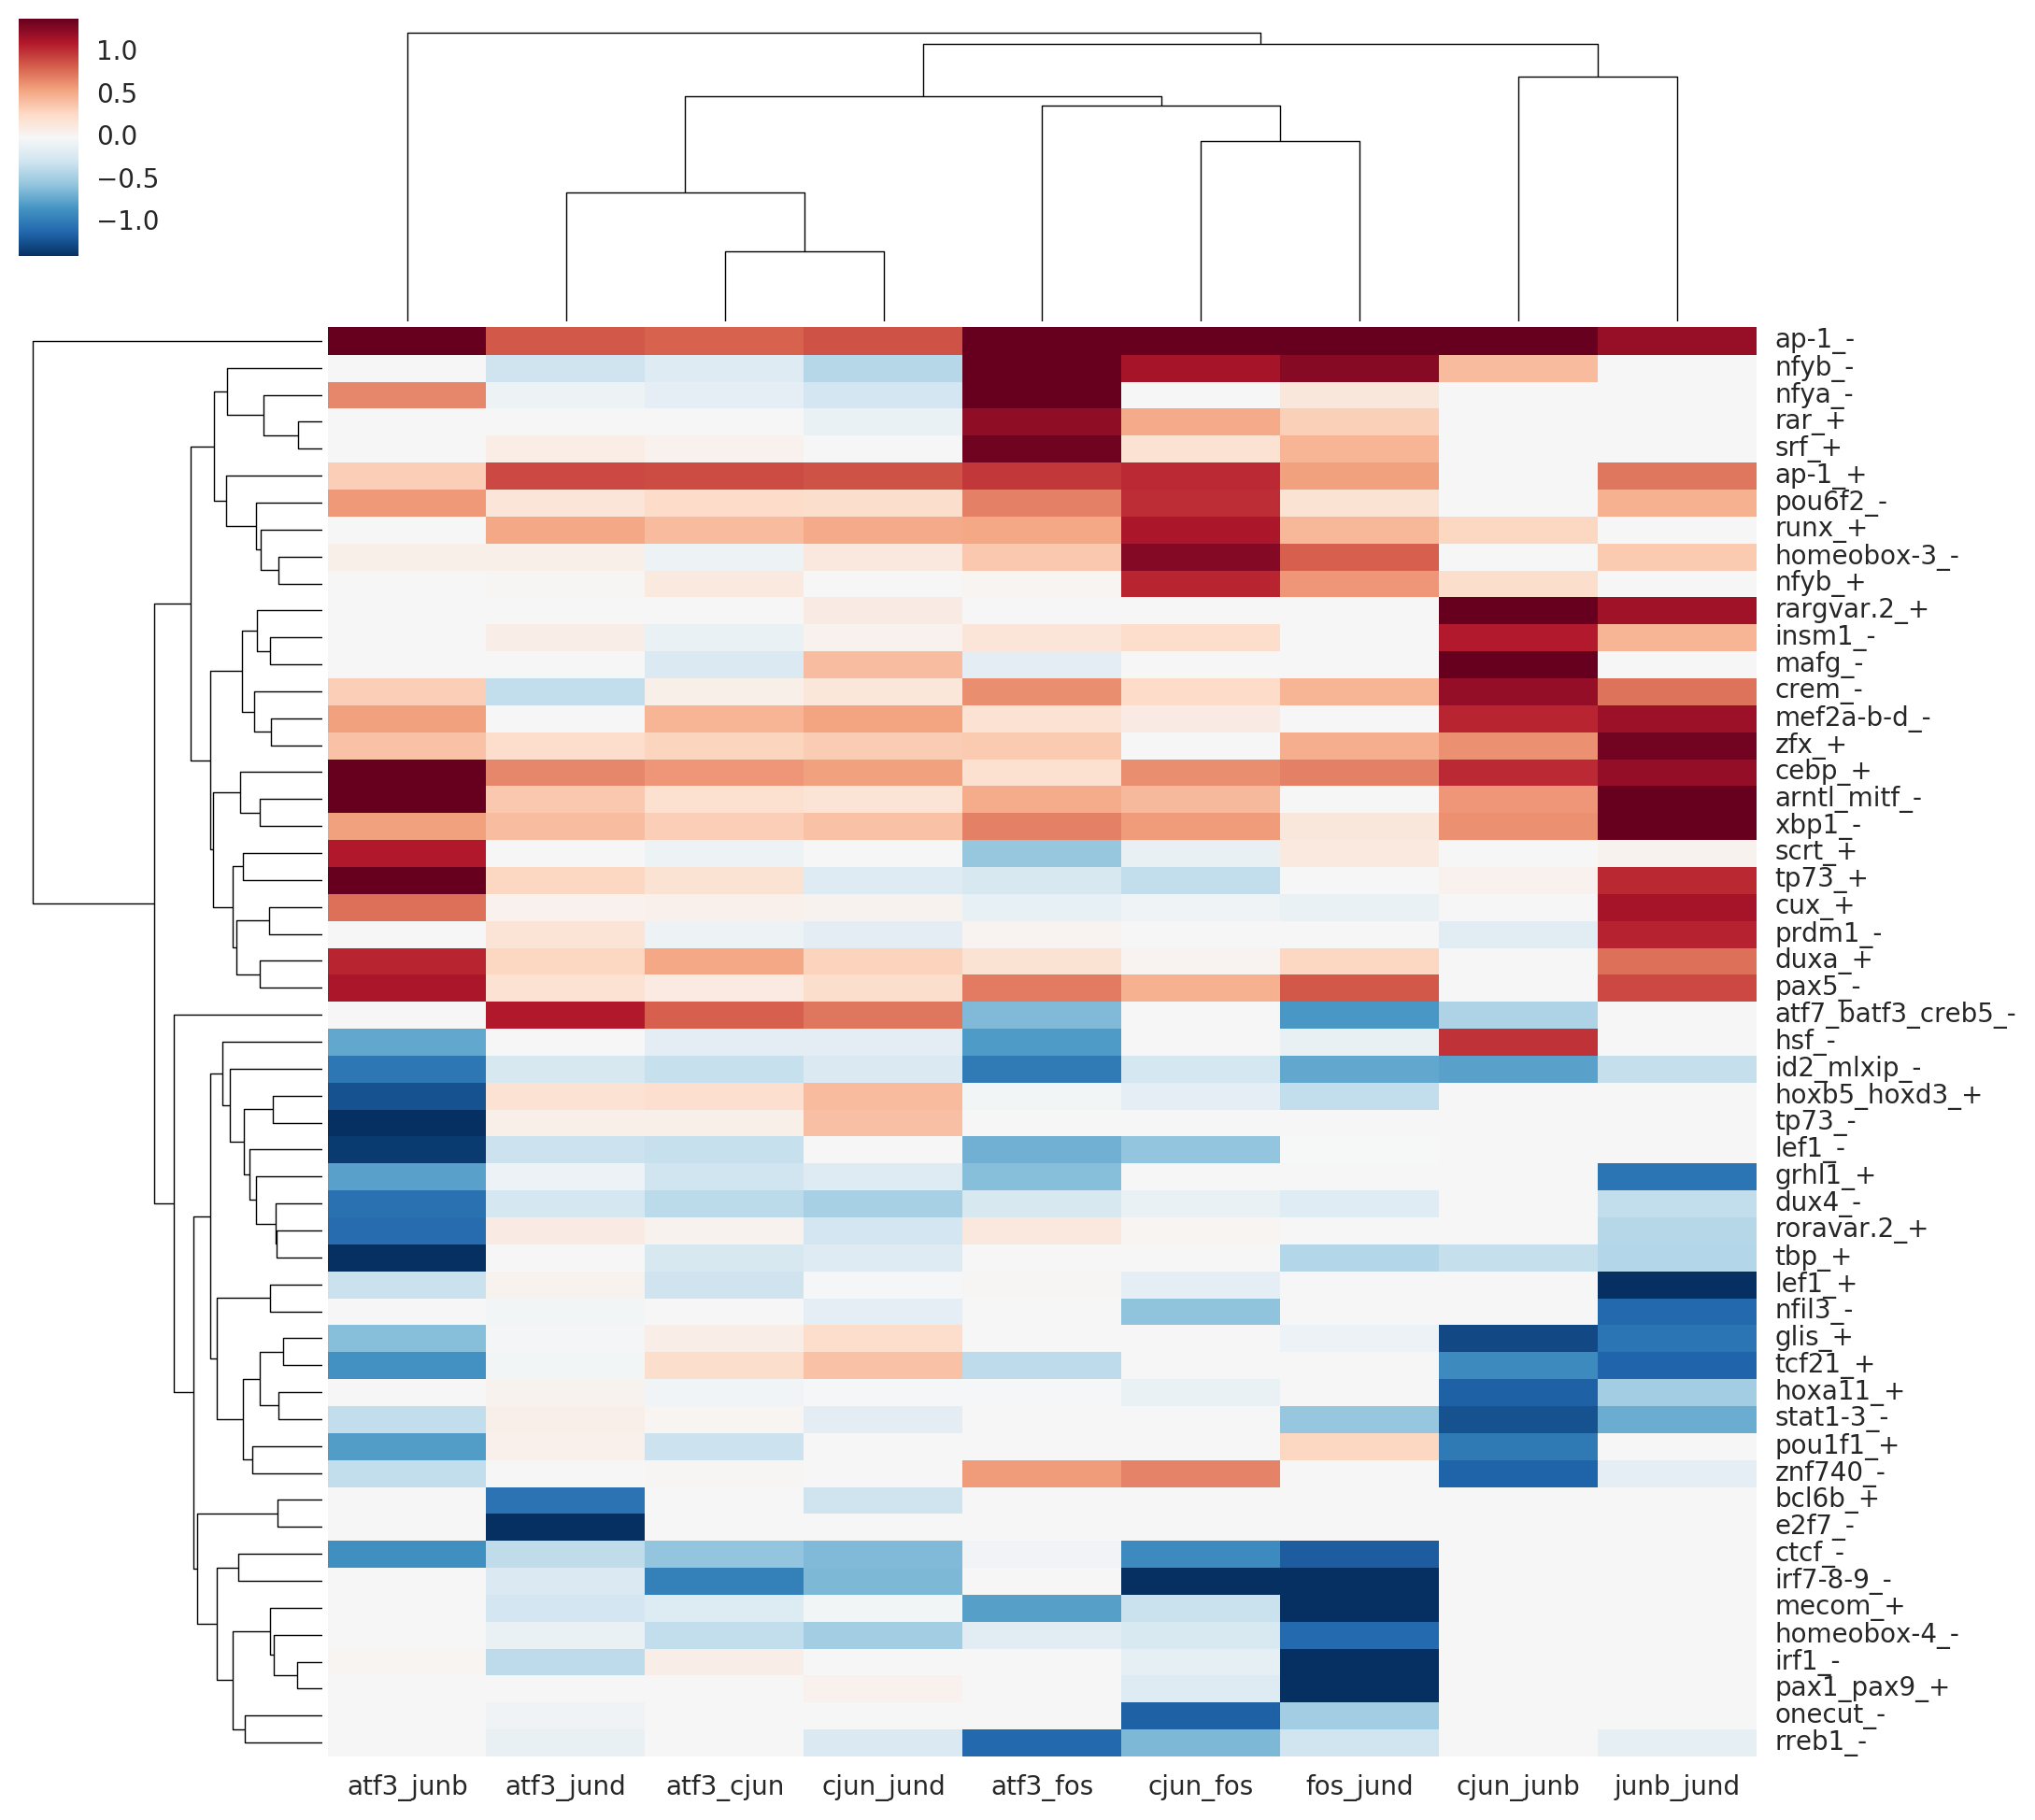

In [38]:
### plot coefficents for vehicle
weight_threshold = 1
data = coefficients_frame_veh[[ x for x in coefficients_frame_veh.columns.values if not x =='fos_junb']]
# data = coefficients_frame_veh
cg = sns.clustermap(data[(data.max(axis=1) >= weight_threshold) |
                                       (data.min(axis=1) < -1 * weight_threshold)
                                      ],
                   vmax=-1.4,
                   vmin=1.4,
                   center = 0.0,
#                    annot=True,annot_kws={"size": 4},
#                     square=True,
                   figsize=(12,12),
                   xticklabels=[x.replace('c57bl6_','') for x in data.columns.values])
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0, );


In [40]:
normed_motif_frame

,alx1_alx4_arx_+,alx1_alx4_arx_-,ap-1_+,ap-1_-,ar_nr3c1_nr3c2_+,ar_nr3c1_nr3c2_-,arid3a_+,arid3a_-,arid3b_+,arid3b_-,...,znf263_+,znf263_-,znf354c_+,znf354c_-,znf410_+,znf410_-,znf423_+,znf423_-,znf740_+,znf740_-
Merged-chr7-137420726-12,0.000000,0.183007,0.000000,0.000000,0.000000,0.000000,1.000000,0.046244,0.270086,0.676358,...,0.300603,0.000000,0.818698,0.818698,0.00000,0.000000,0.000000,0.000000,0.159708,0.415260
Merged-chr16-92801785-16,0.000000,0.000000,0.270505,0.209714,0.000000,0.000000,0.000000,0.055782,0.235656,0.256313,...,0.575132,0.084901,0.790071,0.780529,0.00000,0.000000,0.000000,0.000000,0.328633,0.475900
Merged-chr3-58520496-24,0.000000,0.000000,0.308500,0.696043,0.000000,0.000000,0.761561,0.608960,0.635042,0.091050,...,0.153533,0.130656,0.045765,0.532427,0.00000,0.000000,0.362374,0.054776,0.055754,0.000000
Merged-chr13-52892178-25,0.487123,0.455339,1.000000,0.946801,0.000000,0.000000,1.000000,0.122544,0.600612,0.586841,...,0.052219,0.000000,0.036223,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Merged-chr11-109369232-29,0.000000,0.000000,0.270505,0.270505,0.000000,0.000000,0.000000,0.055782,0.000000,0.173682,...,0.280994,0.000000,0.694647,1.000000,0.00000,0.000000,0.000000,0.000000,0.397935,0.623168
Merged-chr10-93234970-30,0.050415,0.066294,0.946801,1.000000,0.090032,0.192157,0.000000,0.599423,0.538638,0.538638,...,0.000000,0.323480,0.723274,0.904580,0.00000,0.000000,0.000000,0.000000,0.254998,0.116394
Merged-chr1-86529165-4,0.075805,0.071851,1.000000,0.946801,0.000000,0.000000,0.046244,0.046244,0.000000,0.517981,...,0.633962,0.000000,0.351122,1.000000,0.00000,0.000000,0.133011,0.442911,0.000000,0.341627
Merged-chr9-120215355-4,0.000000,0.016274,0.000000,0.000000,0.000000,0.000000,0.046244,0.055782,0.256313,0.263200,...,0.464012,0.000000,0.055307,0.351122,0.00000,0.000000,0.000000,0.000000,0.000000,0.203022
Merged-chr3-88296676-4,0.019947,0.000000,0.262906,0.217313,0.000000,0.000000,0.599423,0.046244,0.311401,0.462893,...,0.117583,0.225434,0.809156,0.074392,0.00000,0.000000,0.000000,0.000000,0.406598,0.341627
Merged-chr1-180393261-4,0.000000,0.000000,0.209714,0.270505,0.103220,0.006396,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.303871,0.074392,0.446545,0.00000,0.000000,0.894494,0.726021,0.000000,0.332964


In [39]:
_id_sequence_dict

{'Merged-chr7-105392539-2': 'CAAGGCCAGCCTAAGCTATATAGCAGGTCCCCAACTAGCTCAAACGAAAAAAGCATCTGTTTAAGTCCGAGGGAAAAAAACAAGATGGAAGAAAGGGGAAGACAATGAAAAGGGGAACAGACAACAGTTTTAAGCATGTTAAATTTTGAGACACTTAAAGAATACTTCAGATATCCAGACAATGGGCTAGGAATGCAGCCTCATTGG',
 'Merged-chr8-128452058-1': 'AGTGTGAGAAGCATAGCTGGCTACTTGGTGCTGACTGTTTCATCTTTACAGATCTTCATGGTCAATTCTGCTCTTCCTGTGTGCCCCACTCCCTTCCTCTTCCTGTCTACTTGCAGAATCCTACTATAGAATCTTTGCTACACACTTGGACATCACAGTCAGCTGTGAAATGTCTCCCCTCCCCCACCCTTCCCAATGTT',
 'Merged-chr5-66269819-1': 'ATATTTAGAAAATGTGTGAAATAAACGAGGAAAGGGTTCTAGCTGTTATGCAAGAAACAACATAGACATCTGATCCCCGAGAGGACAAAAAAATGAGTAAGCTGAGCCTTACAACAGTCTTGGCCTCACGCCTAGAGGGACTTTCCAACTTGTGATATAGGAAATGGAAAACAGACATCTCCCTGAATTAAGAAAGCAGAGATCCGTTTTAAAGGCCGCAGTGACTTTTTTCTTTATTCTAAG',
 'Merged-chr10-111517038-4': 'GAAAGACAGGCAGGCCAGCTTTACGGTGTGCGGTTTACATCTTAGATCTTGGGACAGCACCAAGAAGACAGCTGGCTTCTTCAGAGGTTTGAGCACCCTGCTTTGCGGGTTGGTCCTAGCCCTCTAAACATTCATTACAAAACAGAGACCTATTTTGTAGCAGAGGTGCAGGTCCTGTGTAATTTCCTGTGGTGCAGTTTCAAAACTTGCTAGAGGGAATGGCTC